#  Eikonal Equation segmentation graphs

In [6]:
# load the basic libs
import numpy as np
import matplotlib.image as mpimg
from graph import graph, graph_patch
from utilities import *
from filtering_iso import filtering
from matplotlib import pyplot as plt
from skimage.morphology import opening, square

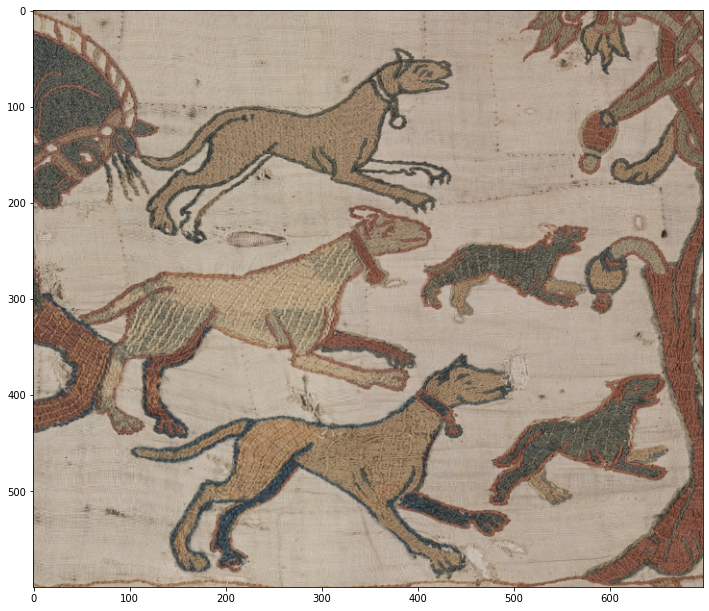

In [22]:
# load the image  # can do the surface example here
img = mpimg.imread("./data/abder/chien_color_crop2.png")
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(img, cmap="gray")
plt.show()

In [23]:
img.shape

(600, 697, 4)

# Let's filter the image on gpu before creating a graph from it.

In [7]:
fmat = imgPatches(img,(3,3))

ip = graph_patch.initialParams(fmat,30,10000)
gr = graph_patch.buildGraph(ip)

hp = filtering.hyperParams(0.0,500,5e-18,1)

new_fmat = filtering.isoFilter(gr,toFmat(img),hp)
new_img = toImg(new_fmat, img.shape)

/home/azad/phd/lib/python3.6/site-packages/bufferkdtree/neighbors/base.py:257: Warning: 
                The performance of the many-core implementation 
                decreases for large values of 'n_neighbors'!
  , Warning)


<pyopencl.Platform 'NVIDIA CUDA' at 0x3a78ea0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>
<pyopencl.Context at 0x30cdcf0 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>>
total time taken by the gpu python: 20.830796003341675



<pyopencl.Platform 'NVIDIA CUDA' at 0x3a78ea0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>
<pyopencl.Context at 0x7f61b4e49dc0 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>>
time taken is 41.922629833221436



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


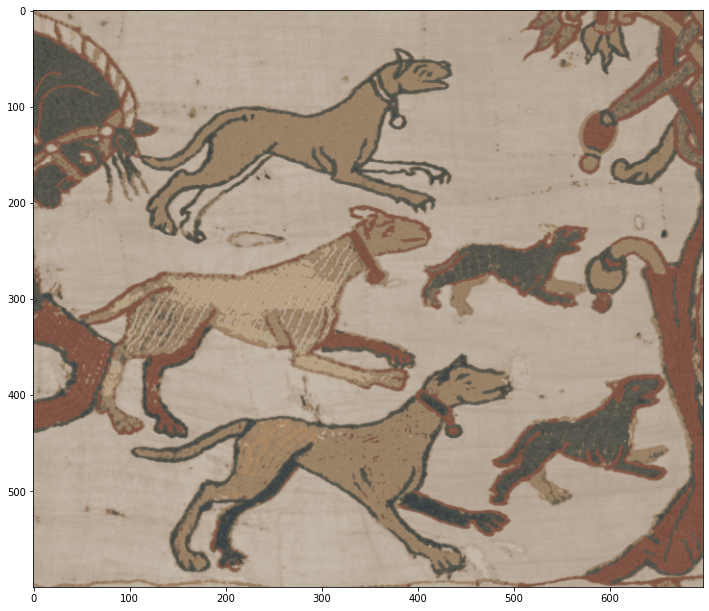

In [8]:
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(new_img, cmap="gray")
plt.show()

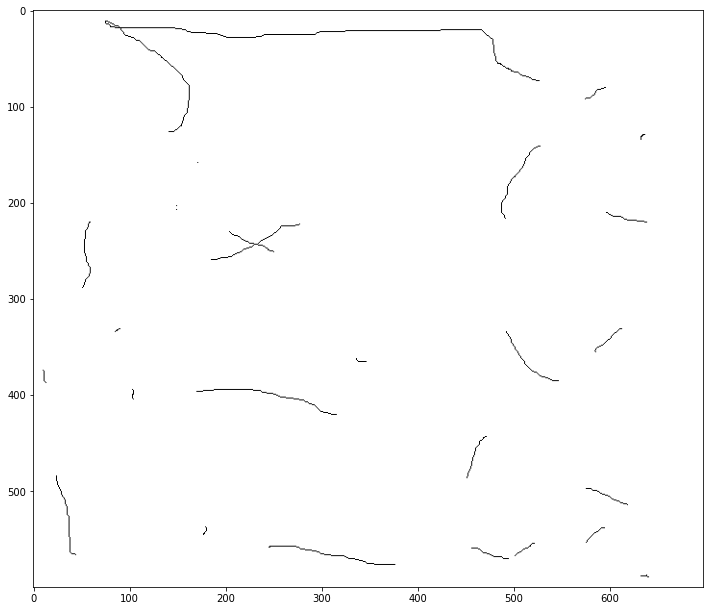

In [9]:
# load the seed image (workflow to create them is pdraw, plabeling and plabel selection)
Front = []  # tiff should be preffered than png
for i in range(0,1,1):
    seed = mpimg.imread(f"./data/abder/out_chien.tiff")
    seed = np.dstack([seed, seed, seed])
    initial_dist = getDist(seed)
    Front.append(initial_dist)
    #Front.append(255*intial_dist)
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(Front[0], cmap="gray")
plt.show()

# Create the new graph before running the eikonal equation

In [14]:
new_img = (new_img - np.min(new_img)) / (np.max(new_img) - np.min(new_img))
ip = graph.initialParams(pMat(new_img.shape), toFmat(new_img), 30,0.5e-02)
gr = graph.buildGraph(ip)

/home/azad/phd/lib/python3.6/site-packages/bufferkdtree/neighbors/base.py:257: Warning: 
                The performance of the many-core implementation 
                decreases for large values of 'n_neighbors'!
  , Warning)



<pyopencl.Platform 'NVIDIA CUDA' at 0x3a78ea0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>
<pyopencl.Context at 0x528c4f0 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>>





In [15]:
# know your weights this can be important at times
# to adjust the values of sigma and k
get_wgStats(gr.wgts)



'The max is 1.0; The min is 0.0; The std is 0.3128367066383362;  The median is 4.596299731929321e-06; The mean is 0.16950711607933044'

# The eikonal equation:
- We shall be runnning the following eikonal equation with the negative $\infty$- norm of the gradient on graphs.
$$ \frac{\partial f}{\partial t} = 1 - \|\nabla_{w}^{-}f\|_{\infty}$$

In [16]:
# evolve the seeds using the graph created above
# for all the seeds in the seed image
from eikonal_eq import eikonal
new_front = []
"""
{{{OPTIMIZATION}}}: azad mer. 12 févr. 2020 08:58:42 CET
Simulatenous evolution of the front on the gpu is possible
and can be deployed. Will make the code much faster.
"""
import time 
start = time.time()
for fr in [Front[0]]:
    hp = eikonal.hyperParams(1,800, 1)  # best
    nf = eikonal.eikonal(gr, toFmat(fr), hp) 
    new_front.append(nf)
end = time.time() - start
print(f"the time taken is {end}")




<pyopencl.Platform 'NVIDIA CUDA' at 0x3a78ea0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>
<pyopencl.Context at 0x8065c10 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x3a78a60>>

the time taken is 2.718406915664673


# Visualize the distance image

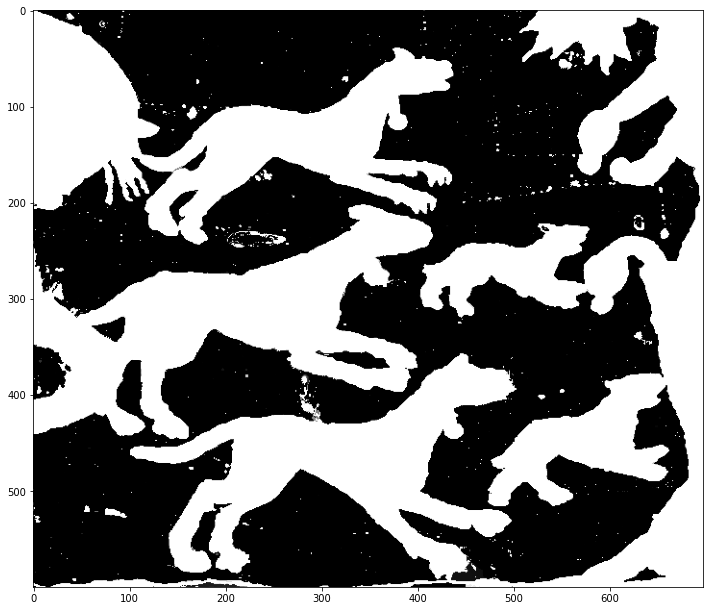

In [17]:
dist_img = []
for fr in new_front:
    tmp_img = toImg(fr, img.shape[0:2])
    dist_img.append(tmp_img)

f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(dist_img[0], cmap="gray")
plt.show()

# Process the distance image
- Fitler, morphological operations or thresholding as required.

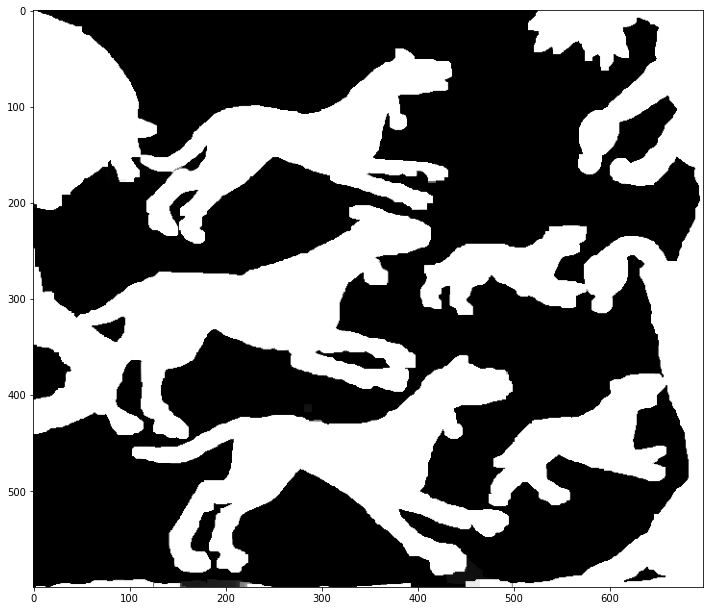

In [18]:
new_img2 = opening(dist_img[0], square(8))
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(new_img2, cmap="gray")
plt.show()

# Visualize the final image segmented image

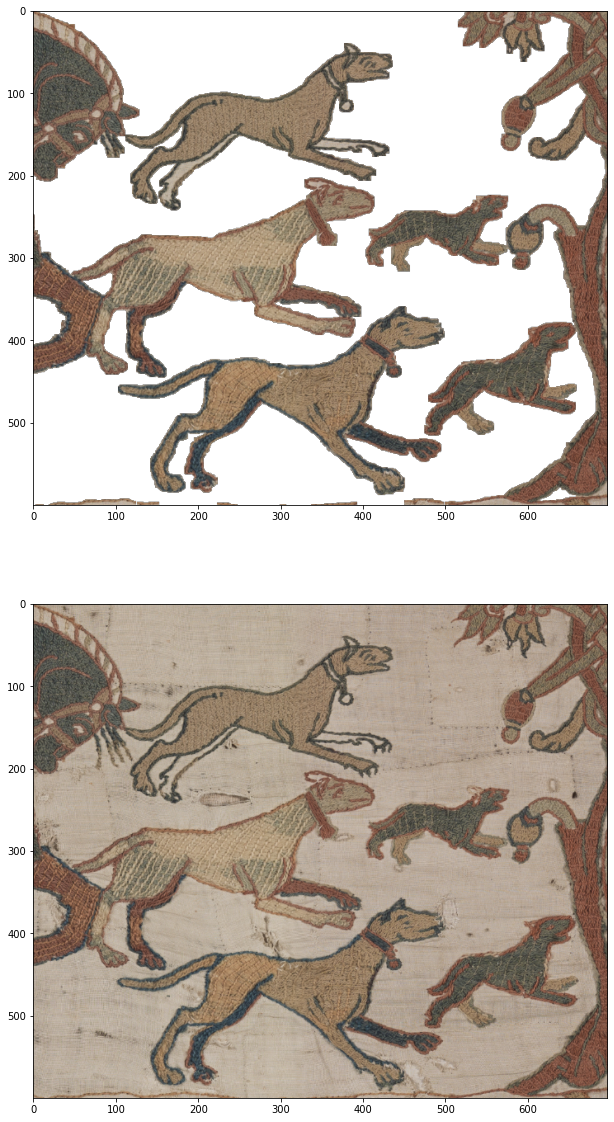

In [21]:
dist2 = (new_img2 - np.min(new_img2)) / (np.max(new_img2) - np.min(new_img2))
dist2 = np.where(dist2 > 0.9, 1, 0)

img3 = np.zeros(np.shape(img))
img3[:,:,0] = dist2 * img[:,:,0]
img3[:,:,1] = dist2 * img[:,:,1]
img3[:,:,2] = dist2 * img[:,:,2]
img3[:,:,3] = dist2 * img[:,:,3]

f = plt.figure(figsize=(20,20))
f.add_subplot(2,1, 1)
plt.imshow(img3)
f.add_subplot(2,1, 2)
plt.imshow(img)
plt.show()